
##Question 1




In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


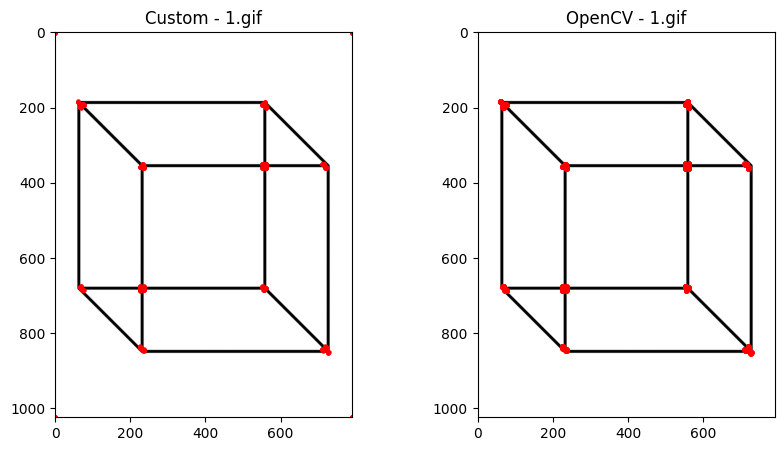

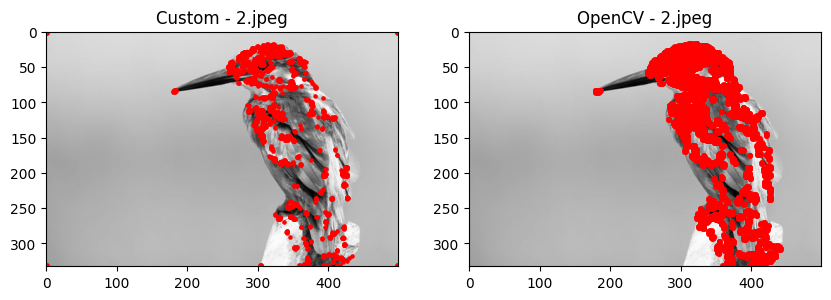

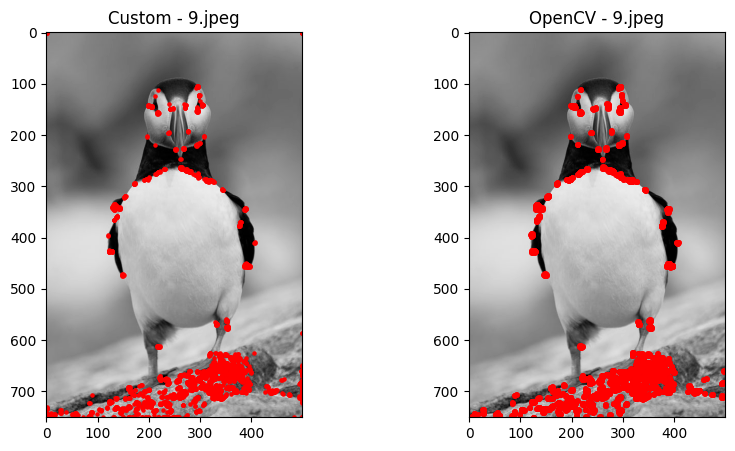

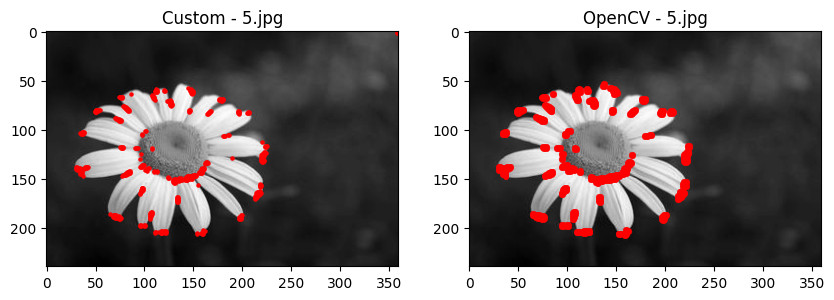

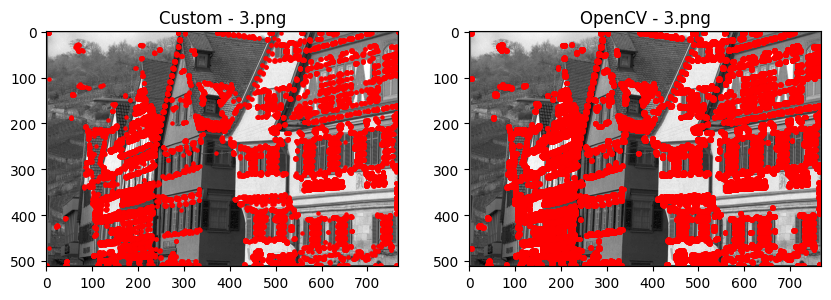

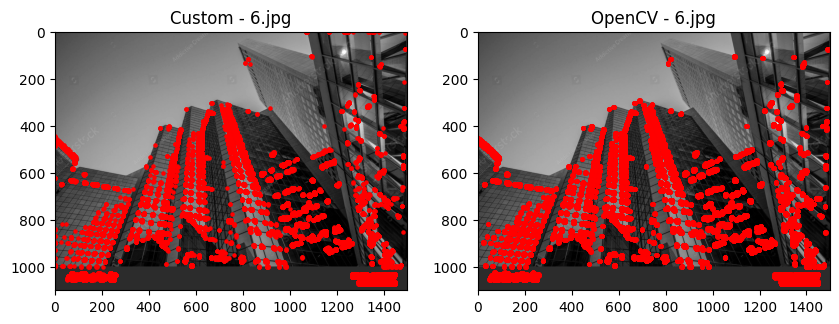

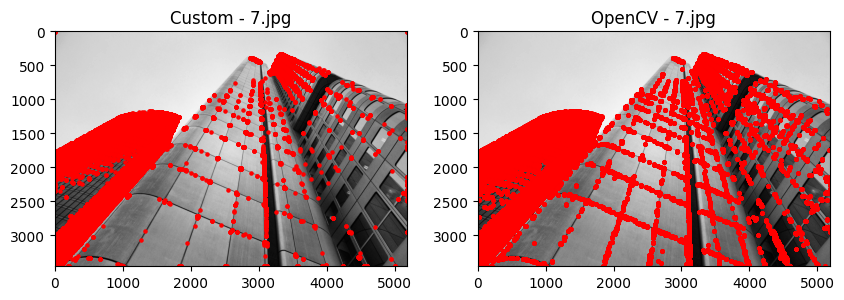

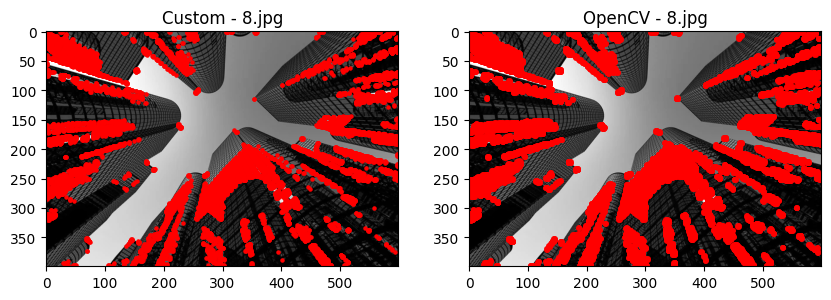

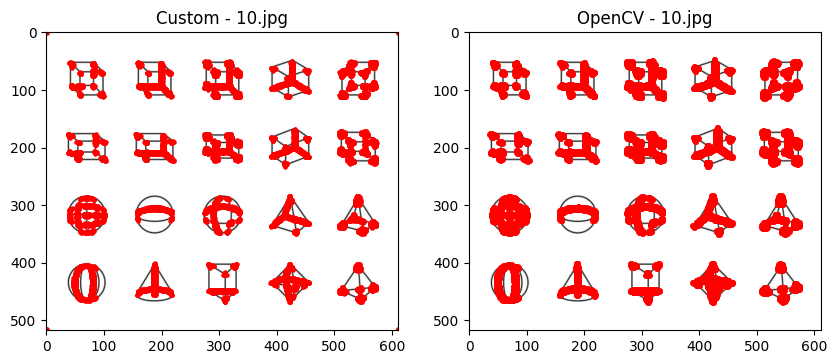

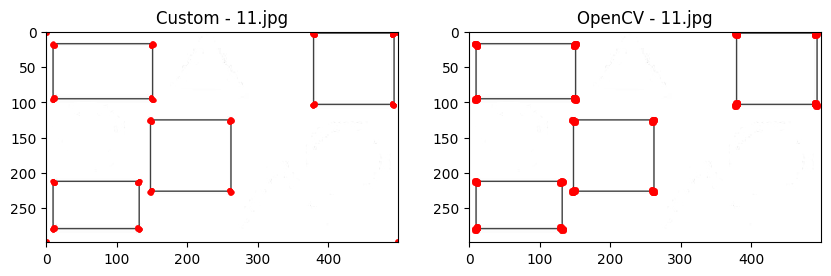

In [87]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def convolution2d(image, kernel):
    m, n = kernel.shape
    img_h, img_w = image.shape[:2]
    pad_h = m // 2
    pad_w = n // 2
    output = np.zeros((img_h, img_w))
    image_padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    for y in range(img_h):
        for x in range(img_w):
            output[y, x] = np.sum(image_padded[y:y+m, x:x+n] * kernel)
    return output

def gaussian_kernel(size, sigma=1):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    kernel_2D = np.exp(-0.5 * (np.square(kernel_1D) / np.square(sigma)))
    return np.outer(kernel_2D, kernel_2D)

def harris_corner_detection_custom(image, window_size=3, k=0.04, threshold=0.01):
    kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    Ix = convolution2d(image, kernel_x)
    Iy = convolution2d(image, kernel_y)
    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix * Iy
    kernel = gaussian_kernel(window_size, sigma=1.0)
    Sxx = convolution2d(Ixx, kernel)
    Syy = convolution2d(Iyy, kernel)
    Sxy = convolution2d(Ixy, kernel)
    det = Sxx * Syy - Sxy**2
    trace = Sxx + Syy
    R = det - k * (trace**2)
    corners = np.zeros_like(image)
    corners[R > threshold * R.max()] = 255
    return corners.astype(np.uint8)

def harris_corner_detection_opencv(image, window_size=3, k=0.04, threshold=0.01):
    corners = cv2.cornerHarris(image, window_size, 3, k)
    corners = cv2.dilate(corners, None)
    return corners

def read_image(filepath):
    _, ext = os.path.splitext(filepath)
    if ext.lower() == '.gif':
        with Image.open(filepath) as img:
            img_gray = img.convert('L')
            return np.array(img_gray)
    else:
        return cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

def visualize_corners(image1, corners1, title1, image2, corners2, title2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1, cmap='gray')
    y1, x1 = np.where(corners1 > 0.01 * corners1.max())
    axes[0].scatter(x1, y1, c='r', s=5)
    axes[0].set_title(title1)

    axes[1].imshow(image2, cmap='gray')
    y2, x2 = np.where(corners2 > 0.01 * corners2.max())
    axes[1].scatter(x2, y2, c='r', s=5)
    axes[1].set_title(title2)

    plt.show()

def detect_and_compare_corners(folder_path, window_size=3, k=0.04, threshold=0.01):
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg') or filename.endswith('.gif'):
            filepath = os.path.join(folder_path, filename)
            image = read_image(filepath)

            # Custom implementation
            corners_custom = harris_corner_detection_custom(image, window_size, k, threshold)

            # OpenCV's corner detection
            corners_opencv = harris_corner_detection_opencv(image, window_size, k, threshold)

            # Visualize results side by side
            visualize_corners(image, corners_custom, f'Custom - {filename}',
                              image, corners_opencv, f'OpenCV - {filename}')

def main():
    folder_path = '/content/drive/MyDrive/data_sets/cv_data/Assignment 1 Input Images/Question 1'
    detect_and_compare_corners(folder_path)

if __name__ == "__main__":
    main()


##Question 2

In [88]:
import cv2
import numpy as np

import matplotlib.pyplot as plt


def read_camera_parameters(txt_file_path):
    camera_parameters = []
    baseline = None
    with open(txt_file_path, 'r') as f:
        for line in f:
            if line.startswith('cam'):
                values = line.split('=')[1].strip()[1:-1]
                values = values.replace(';', ' ').split()
                intrinsics = [float(val) for val in values]
                camera_parameters.append(np.array(intrinsics).reshape(3, 3))
            elif line.startswith('baseline'):
                baseline = float(line.split('=')[1])
    return camera_parameters, baseline

def stereo_rectification(K_left, K_right, baseline, img_left, img_right):
    R = np.eye(3)  # No rotation between the cameras
    T = np.array([baseline, 0, 0])  # Translation between the cameras
    size = img_left.shape[::-1]
    R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(K_left, None, K_right, None, size, R, T)

    map_left_x, map_left_y = cv2.initUndistortRectifyMap(K_left, None, R1, P1, size, cv2.CV_32FC1)
    map_right_x, map_right_y = cv2.initUndistortRectifyMap(K_right, None, R2, P2, size, cv2.CV_32FC1)
    img_left_rectified = cv2.remap(img_left, map_left_x, map_left_y, cv2.INTER_LINEAR)
    img_right_rectified = cv2.remap(img_right, map_right_x, map_right_y, cv2.INTER_LINEAR)

    return img_left_rectified, img_right_rectified, Q

def compute_disparity(img_left_rectified, img_right_rectified):
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
    disparity = stereo.compute(img_left_rectified, img_right_rectified)
    return disparity

def compute_depth_map(disparity, K_left, baseline):
    depth_map = np.zeros_like(disparity, dtype=np.float32)
    nonzero_indices = disparity > 0
    depth_map[nonzero_indices] = baseline * K_left[0, 0] / disparity[nonzero_indices]
    return depth_map

def reconstruct_point_cloud(disparity, Q):
    points_3d = cv2.reprojectImageTo3D(disparity, Q)
    return points_3d

def save_results(disparity, depth_map, points_3d):
    cv2.imwrite("disparity_map.png", disparity)
    cv2.imwrite("depth_map.png", depth_map)
    np.save("point_cloud.npy", points_3d)

# Example usage:

txt_file_path = "/content/drive/MyDrive/data_sets/cv_data/Assignment 1 Input Images/Question 2 and 3 Images/bike.txt"
left_image_path = "/content/drive/MyDrive/data_sets/cv_data/Assignment 1 Input Images/Question 2 and 3 Images/bikeL.png"
right_image_path = "/content/drive/MyDrive/data_sets/cv_data/Assignment 1 Input Images/Question 2 and 3 Images/bikeR.png"

# Read camera parameters
camera_parameters, baseline = read_camera_parameters(txt_file_path)
if len(camera_parameters) != 2 or baseline is None:
    print("Failed to read camera parameters and baseline from file.")
    exit()

K_left = camera_parameters[0]
K_right = camera_parameters[1]

# Load stereo images
img_left = cv2.imread(left_image_path, 0)
img_right = cv2.imread(right_image_path, 0)

# Stereo rectification
img_left_rectified, img_right_rectified, Q = stereo_rectification(K_left, K_right, baseline, img_left, img_right)

# Compute disparity
disparity = compute_disparity(img_left_rectified, img_right_rectified)

# Calculate depth map
depth_map = compute_depth_map(disparity, K_left, baseline)

# Reconstruct 3D point cloud
points_3d = reconstruct_point_cloud(disparity, Q)

# Save results
save_results(disparity, depth_map, points_3d)

print("Disparity Map:")
print(disparity)
print("Depth Map:")
print(depth_map)
print("3D Point Cloud:")
print(points_3d)


Disparity Map:
[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]
Depth Map:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
3D Point Cloud:
[[[-14968.77  -10834.103  58719.04 ]
  [-14957.688 -10834.103  58719.04 ]
  [-14946.608 -10834.103  58719.04 ]
  ...
  [ 18106.523 -10834.103  58719.04 ]
  [ 18117.604 -10834.103  58719.04 ]
  [ 18128.684 -10834.103  58719.04 ]]

 [[-14968.77  -10823.021  58719.04 ]
  [-14957.688 -10823.021  58719.04 ]
  [-14946.608 -10823.021  58719.04 ]
  ...
  [ 18106.523 -10823.021  58719.04 ]
  [ 18117.604 -10823.021  58719.04 ]
  [ 18128.684 -10823.021  58719.04 ]]

 [[-14968.77  -10811.941  58719.04 ]
  [-14957.688 -10811.941  58719.04 ]
  [-14946.608 -10811.941  58719.04 ]
  ...
  [ 18106.523 -10811.941  58719.0

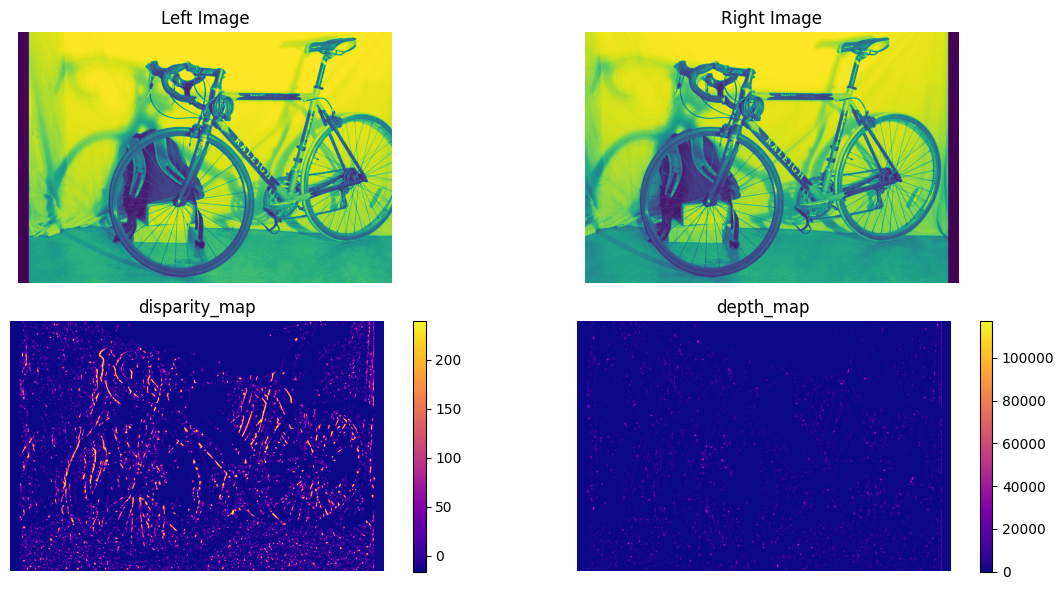

In [89]:
import matplotlib.pyplot as plt



# Display results
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title('Left Image')
plt.imshow(img_left_rectified)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Right Image')
plt.imshow(img_right_rectified)
plt.axis('off')


plt.subplot(2, 2, 3)
plt.title('disparity_map')
plt.imshow(disparity, cmap='plasma')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('depth_map')
plt.imshow(depth_map, cmap='plasma')
plt.colorbar()
plt.axis('off')



plt.tight_layout()
plt.show()

##Question 3

In [90]:
import numpy as np
import cv2

# Load images
image1 = cv2.imread('/content/drive/MyDrive/data_sets/cv_data/Assignment 1 Input Images/Question 2 and 3 Images/000000.png', 0)  # Grayscale
image2 = cv2.imread('/content/drive/MyDrive/data_sets/cv_data/Assignment 1 Input Images/Question 2 and 3 Images/000023.png', 0)  # Grayscale

# Define Fundamental matrix
F = np.array([[3.34638533e-07, 7.58547151e-06, -2.04147752e-03],
              [-5.83765868e-06, 1.36498636e-06, 2.67566877e-04],
              [1.45892349e-03, -4.37648316e-03, 1.00000000e+00]])

# Find epipolar lines
def find_epipolar_lines(F, point, img_shape):
    line = np.dot(F, point)
    t = np.linspace(0, img_shape[1], 100)
    lt = np.array([(line[2] + line[0]*tt) / (-line[1]) for tt in t])
    return np.vstack([t, lt, np.ones_like(t)]).T

# Draw epipolar lines
def draw_epipolar_lines(img, lines):
    for line in lines:
        x0, y0 = map(int, [0, -line[0][2] / line[0][1]])
        x1, y1 = map(int, [img.shape[1], -(line[0][2] + line[0][0] * img.shape[1]) / line[0][1]])
        cv2.line(img, (x0, y0), (x1, y1), (0, 0,255), 1)

# Sample points on epipolar lines
def sample_points_on_line(line, num_points):
    step = line.shape[0] // num_points
    return line[::step]

# Find corresponding points on the other epipolar line
def find_corresponding_points(F, point, img_shape):
    line = np.dot(F, point)
    t = np.linspace(0, img_shape[1], 100)
    lt = np.array([(line[2] + line[0]*tt) / (-line[1]) for tt in t])
    corresponding_points = np.vstack([t, lt, np.ones_like(t)]).T
    corresponding_points[:, 1] = np.clip(corresponding_points[:, 1], 0, img_shape[0] - 1)
    return corresponding_points

# Choose a point in the first image
point1 = np.array([100, 100, 1])

# Find its epipolar line in the second image
epipolar_line2 = find_epipolar_lines(F.T, point1, image2.shape)

# Choose a point in the second image
point2 = np.array([150, 150, 1])

# Find its epipolar line in the first image
epipolar_line1 = find_epipolar_lines(F, point2, image1.shape)

# Draw epipolar lines on images
image1_with_lines = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
image2_with_lines = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)
draw_epipolar_lines(image1_with_lines, [epipolar_line1])
draw_epipolar_lines(image2_with_lines, [epipolar_line2])



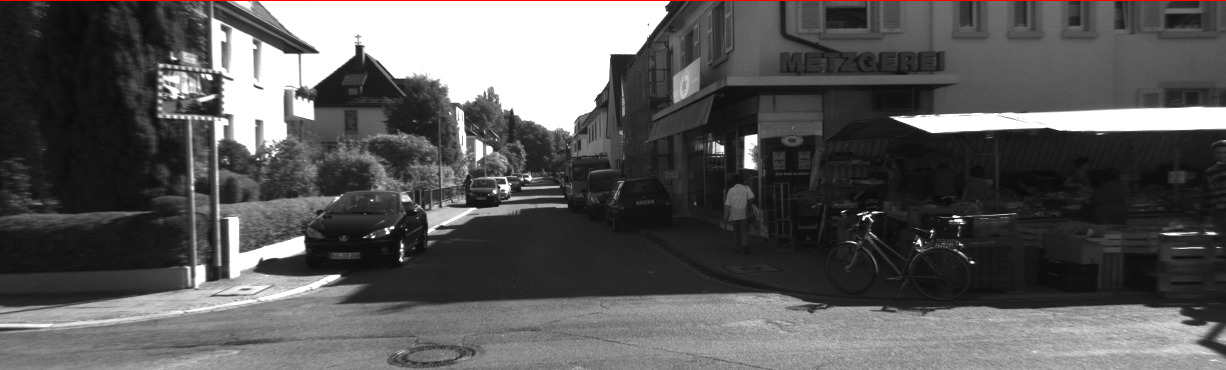

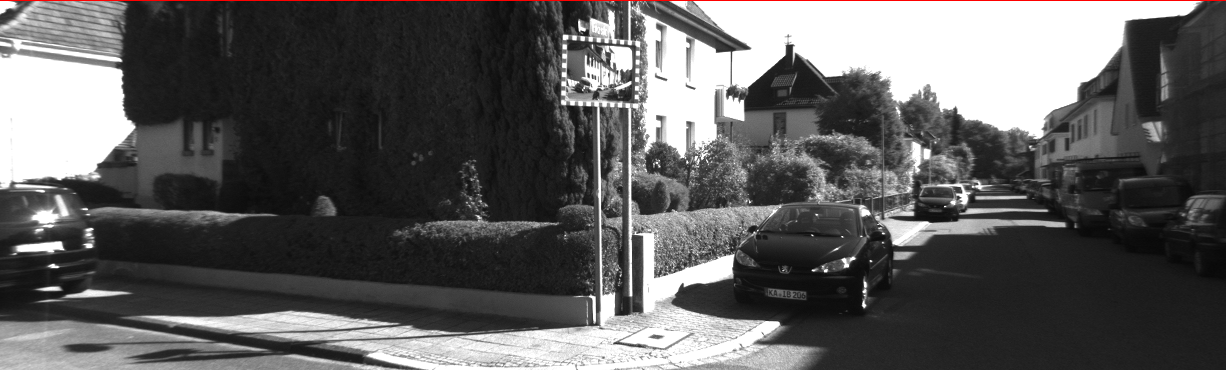

In [91]:
from google.colab.patches import cv2_imshow

# Display images
cv2_imshow(image1_with_lines)
cv2_imshow(image2_with_lines)